In [1]:
import torch
from math import pi,sqrt,log,e,exp
from time import time
from matplotlib import pyplot
import numpy as np
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
#torch.set_default_dtype(torch.float64)
device = torch.device("cuda:7")

In [2]:
from src.models.flows.coupling_cells.real_nvp import RealNVP
from src.models.flows.sampling import FactorizedGaussianSampler, UniformSampler
from src.models.flows.analytic_flows.element_wise import InvertibleAnalyticSigmoid
from src.models.flows.sequential import InvertibleSequentialFlow
from src.training.weighted_dataset.dkl_training import BasicStatefulDKLTrainer
from src import setup_std_stream_rootlogger

In [3]:
setup_std_stream_rootlogger(debug=True)

In [4]:
def f(x):
    return torch.exp(-10*(2*x[:,1]-torch.cos(4*pi*x[:,0])-1)**2)

In [5]:
posterior=UniformSampler(d=2,low=0.,high=1.,device=device)
prior=FactorizedGaussianSampler(d=2,device=device)

In [25]:
try:
    del model
except:
    pass


model  = InvertibleSequentialFlow(2,[
        RealNVP(d=2,
              mask=[True,False],
              d_hidden=256,
              n_hidden=16,).to(device),
        RealNVP(d=2,
              mask=[False,True],
              d_hidden=256,
              n_hidden=16,).to(device),
        RealNVP(d=2,
              mask=[True,False],
              d_hidden=256,
              n_hidden=16,).to(device),
        RealNVP(d=2,
              mask=[False,True],
              d_hidden=256,
              n_hidden=16,).to(device),
    InvertibleAnalyticSigmoid(d=2),
])

optim = torch.optim.Adam(model.parameters(),lr=1.e-4)

In [26]:
trainer = BasicStatefulDKLTrainer(flow=model,latent_prior=prior)

In [28]:
trainer.set_config(n_epochs=100, minibatch_size=20000, optim=torch.optim.Adam(model.parameters()))

In [29]:
x,px,fx = trainer.generate_target_batch_from_posterior(n_points=100000, f=f, target_posterior=posterior)

In [30]:
record = trainer.train_on_batch(x,px,fx)

Training on batch: 100000 points
Epoch 1/100
Loss: 2.151e-01
Loss: 1.550e-01
Loss: 1.093e-01
Loss: 6.520e-02
Loss: 3.367e-02
Epoch 2/100
Loss: 7.495e-03
Loss: -4.999e-04
Loss: 1.072e-02
Loss: 1.761e-02
Loss: 1.614e-02
Epoch 3/100
Loss: 1.140e-02
Loss: 2.541e-03
Loss: -4.628e-03
Loss: -1.012e-02
Loss: -7.912e-03
Epoch 4/100
Loss: -1.094e-02
Loss: -8.972e-03
Loss: -1.294e-02
Loss: -1.469e-02
Loss: -1.327e-02
Epoch 5/100
Loss: -1.739e-02
Loss: -1.601e-02
Loss: -1.859e-02
Loss: -1.940e-02
Loss: -1.758e-02
Epoch 6/100
Loss: -1.996e-02
Loss: -1.788e-02
Loss: -1.995e-02
Loss: -1.922e-02
Loss: -1.826e-02
Epoch 7/100
Loss: -2.006e-02
Loss: -1.907e-02
Loss: -2.012e-02
Loss: -2.130e-02
Loss: -1.832e-02
Epoch 8/100
Loss: -2.134e-02
Loss: -1.958e-02
Loss: -2.084e-02
Loss: -2.167e-02
Loss: -1.900e-02
Epoch 9/100
Loss: -2.216e-02
Loss: -1.945e-02
Loss: -2.094e-02
Loss: -2.186e-02
Loss: -1.885e-02
Epoch 10/100
Loss: -2.204e-02
Loss: -1.989e-02
Loss: -2.143e-02
Loss: -2.203e-02
Loss: -1.963e-02
Epoch 1

Loss: -6.154e-02
Loss: -6.402e-02
Epoch 85/100
Loss: -8.572e-02
Loss: -8.741e-02
Loss: -9.878e-02
Loss: -1.023e-01
Loss: -1.094e-01
Epoch 86/100
Loss: -1.221e-01
Loss: -1.140e-01
Loss: -1.212e-01
Loss: -1.337e-01
Loss: -1.378e-01
Epoch 87/100
Loss: -1.519e-01
Loss: -1.480e-01
Loss: -1.532e-01
Loss: -1.559e-01
Loss: -1.380e-01
Epoch 88/100
Loss: -1.354e-01
Loss: -1.545e-01
Loss: -1.186e-01
Loss: -1.357e-01
Loss: -1.101e-01
Epoch 89/100
Loss: -1.331e-01
Loss: -1.433e-01
Loss: -1.594e-01
Loss: -1.581e-01
Loss: -1.394e-01
Epoch 90/100
Loss: -1.712e-01
Loss: -1.694e-01
Loss: -1.695e-01
Loss: -1.583e-01
Loss: -1.699e-01
Epoch 91/100
Loss: -1.786e-01
Loss: -1.796e-01
Loss: -1.707e-01
Loss: -1.842e-01
Loss: -1.822e-01
Epoch 92/100
Loss: -1.848e-01
Loss: -1.811e-01
Loss: -1.861e-01
Loss: -1.899e-01
Loss: -1.822e-01
Epoch 93/100
Loss: -1.936e-01
Loss: -1.923e-01
Loss: -1.862e-01
Loss: -1.924e-01
Loss: -1.891e-01
Epoch 94/100
Loss: -1.984e-01
Loss: -1.957e-01
Loss: -1.951e-01
Loss: -1.978e-01
Los

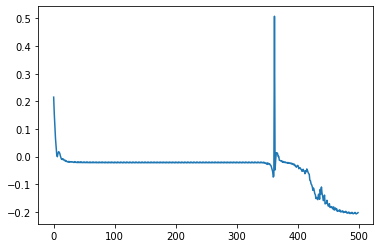

In [31]:
plt.plot(record.losses)
plt.show()

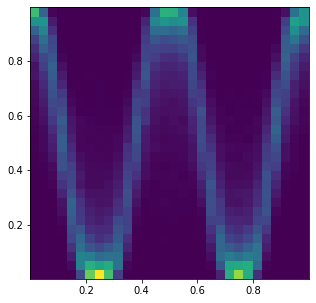

In [32]:
x=trainer.sample_forward(100000).cpu().numpy()
plt.figure(figsize=(5,5))
plt.hist2d(x[:,0],x[:,1],bins=30)
plt.show()